In [1]:
# NumPyをインポート（数値計算、行列操作などで使用）
import numpy as np

# NetworkXをインポート（グラフ構造の生成・操作・アルゴリズム適用に利用）
import networkx as nx

# Matplotlibのpyplotモジュールをインポート（グラフの可視化に利用）
import matplotlib.pyplot as plt

In [2]:
# 各コミュニティ間・内部の接続確率を定義（2×2の行列）
# - probs[i][j] はコミュニティ i と j のノード間の接続確率
# 今回は：
# - 同じコミュニティ内の接続確率 = 0.1（対角成分）
# - 異なるコミュニティ間の接続確率 = 0.02（非対角成分）
probs = [
    [0.1, 0.02],
    [0.02, 0.1],
]

# コミュニティ1のノード数（50個）
n1 = 50

# コミュニティ2のノード数（50個）
n2 = 50

# 総ノード数
n = n1 + n2

# ストキャスティック・ブロック・モデル（SBM）に基づくグラフの生成
# - ノード数：[50, 50] → 2つのコミュニティ
# - 接続確率行列：probs
# - seed：再現性のための乱数シード
G = nx.stochastic_block_model([n1, n2], probs, seed=0)  # グラフの生成

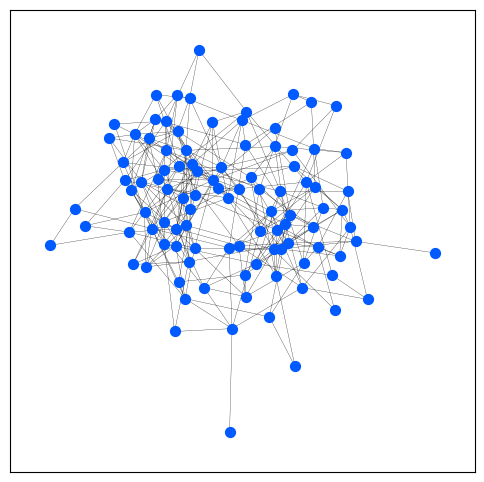

In [3]:
# spring_layout（ばねレイアウト）を使ってノードの描画位置を決定
# - グラフの構造を保ちつつ、ノードが見やすいように配置
# - 引数 seed を指定することで配置の再現性を確保
pos = nx.layout.spring_layout(G, seed=3)

# 描画用のFigureとAxesを作成（正方形のサイズ 6x6インチ）
fig, ax = plt.subplots(figsize=(6, 6))

# グラフを描画（NetworkXの draw_networkx を使用）
nx.draw_networkx(
    G,  # 対象のグラフ
    pos,  # ノードの位置（上で spring_layout により定義）
    ax=ax,  # 描画に使用する Axes オブジェクト
    with_labels=False,  # ノードラベル（番号など）は描画しない
    width=0.2,  # エッジの線の太さ
    node_size=50,  # ノードの大きさ（ピクセル単位）
    node_color="#005aff",  # ノードの色（青系）
)

In [4]:
# 訓練データに用いるノード数を指定（ここでは20個）
nL = 20

# 全ノード n (= 100) からランダムに20個を選び、訓練用ノード集合 L とする
# - replace=False により、同じノードが重複して選ばれることはない
# - np.random.choice によりランダム抽出が行われる（再現性はseed設定が必要）
L = np.random.choice(n, size=nL, replace=False)

# テスト用ノード集合 U を作成
# - 全ノードの集合 set(range(n)) から訓練ノード L を除いたものがテストノード U
# - list(set(...)) で差集合を取り、np.array に変換している
U = np.array(list(set(range(n)) - set(L.tolist())))

In [5]:
# 訓練データ（L）に対応するラベルベクトルを初期化（全て 0 で初期化）
# - サイズ：nL（= 20）
# - データ型：int（整数）
fV = np.zeros(nL, int)

# Lに含まれる各ノード v に対して、確率的にラベルを1に設定（=正例）
for i, v in enumerate(L):
    # v のノードがコミュニティ1（0番目のグループ）に属している場合
    if v < n1:
        p = 0.8  # 正例になる確率を 0.8 に設定（高い確率）
    else:
        p = 0.2  # コミュニティ2の場合は正例になる確率が 0.2（低い確率）

    # 一様乱数（0〜1）を生成して、p 未満なら正例（=1）とする
    if np.random.rand() < p:
        fV[i] = 1  # ラベル 1（正例）を付与

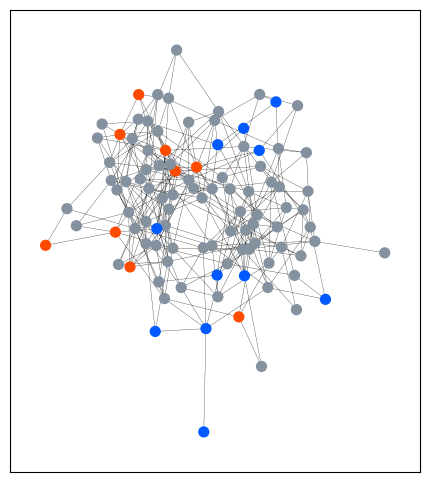

In [6]:
# グラフ可視化用のFigureを作成（横長：幅18インチ × 高さ6インチ）
fig = plt.figure(figsize=(18, 6))

# 1行3列のサブプロットの1つ目（左端）を ax に設定
ax = fig.add_subplot(1, 3, 1)

# ノードの色を格納するリストを初期化（全ノード数分、初期色は0とする）
c = [0 for i in range(n)]

# 各ノード i について、ラベルに応じて色を決定
for i in range(n):
    if i in L and fV[L.tolist().index(i)] == 1:
        # 訓練ノードでラベル1（正例）の場合 → 赤色
        c[i] = "#ff4b00"
    elif i in L and fV[L.tolist().index(i)] == 0:
        # 訓練ノードでラベル0（負例）の場合 → 青色
        c[i] = "#005aff"
    else:
        # テストノード（未ラベル） → グレー
        c[i] = "#84919e"

# ノードのラベル状態を色で可視化してグラフを描画
nx.draw_networkx(
    G,  # グラフ構造
    pos,  # 各ノードの描画位置（spring_layout で生成済み）
    ax=ax,  # 描画先のAxes
    with_labels=False,  # ノードに番号などのラベルは表示しない
    width=0.2,  # エッジの太さ
    node_size=50,  # ノードの大きさ
    node_color=c,  # 上で設定したノードごとの色
)